# Setup
Consider the following data generating process: 

$\begin{align}
y = a + bx + \epsilon,
\end{align}$

where $y\in \mathbb{R}$, $x \in \mathbb{R}$, and $\mathbb{E}[\epsilon|x] = 0$.

We obeserve $\{y_i,x_i\}_{i=1}^N$ and we want to run the following linear regression:

$\begin{align}
y_i = \hat{a}+\hat{b} x_i.
\end{align}$

Here I compare two different approaches to optimization:

1. Gradient Descent

2. Stochastic Gradient Descent: **One** data point at a time

In this experiment:

1. $(a,b) = (1,1)$
2. $\epsilon = 0.1\times \mathcal{N}(0,1)$

#### Importing Packages

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
fontsize= 16
ticksize = 14
figsize = (12, 6)
params_plt = {"text.usetex": True,
    'font.family':'serif',
    "figure.figsize":figsize, 
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize, 
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_plt)

#### Data Generating Process

In [3]:
class Data_gen():
    def __init__(self, 
                 a =1.0,
                b = 1.0,
                N = 32,
                sigma = 0.1):
        torch.manual_seed(0)
        self.a= a
        self.b = b
        self.N = N
        self.sigma = sigma
        self.ϵ = self.sigma*torch.randn(N)
        self.x = torch.arange(0.0,self.N,1)/self.N
        self.y = self.a+ self.b*self.x+self.ϵ
    def train_data(self):
        data = torch.stack((self.x,self.y),1)
        return data


#### Plotting the Data Points

In [4]:
x = Data_gen().train_data()[:,[0]]
y = Data_gen().train_data()[:,[1]] 


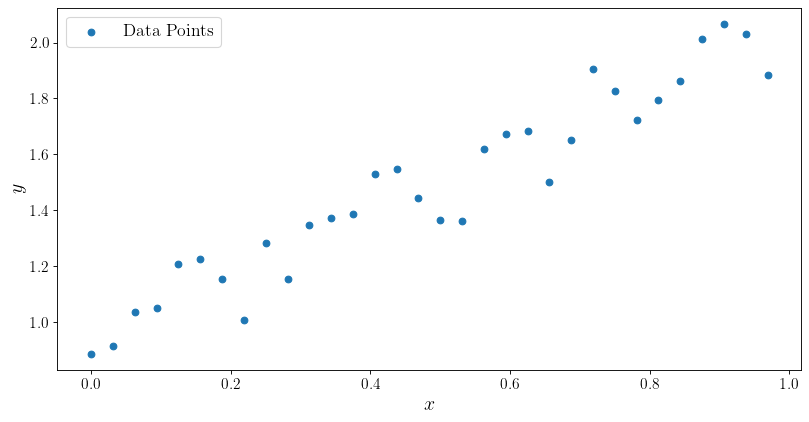

In [5]:
plt.scatter(x,y, zorder=2,label= r"Data Points")
plt.ylabel(r"$y$",fontsize=18)
plt.xlabel(r"$x$",fontsize=18)
plt.legend(loc='best')
plt.show()

#### Finding the OLS estimator

$\begin{align}
\begin{pmatrix}
\hat{a}\\
\hat{b}
\end{pmatrix} = (X'X)^{-1} X'y
\end{align}$

where 

$X \equiv \begin{bmatrix}
1 & x_1\\
1 & x_2\\
\vdots & \vdots\\
1 & x_N
\end{bmatrix}$, and $y \equiv \begin{bmatrix}
y_1\\
y_2\\
\vdots\\
y_N
\end{bmatrix}$.

In [6]:
X = torch.cat((torch.ones([Data_gen().N,1]),x),1)
ols_coeff = torch.inverse(X.t()@X)@X.t()@y

a_hat_ols = ols_coeff[0]
b_hat_ols = ols_coeff[1]
print('a_hat=',round(a_hat_ols.item(),3))
print('b_hat=',round(b_hat_ols.item(),3))


a_hat= 0.949
b_hat= 1.108


#### Designing the Linear Neural Net:
Here we initialize the coefficients to:

1. Intercept: 3.0
2. Slope: -1.5


In [7]:
class NN(nn.Module):
    def __init__(self,
                hidden_bias = True):
        super().__init__()
        self.hidden_bias = hidden_bias
        
        self.fc1 = nn.Linear(1,1, bias = self.hidden_bias)
        #hardcoding the initial weights
        self.fc1.weight.data = torch.tensor([[-1.5]])
        self.fc1.bias.data = torch.tensor([[3.0]])
    
    def forward(self, x):
        p_output = self.fc1(x)
        return  p_output 

#### Designing the Data Loader:
This is required to pass the data one by one to the optimizer

In [8]:
class Dataset_loader(Dataset):
    def __init__(self):
        self.train_data = Data_gen().train_data()
        self.x = self.train_data[:,[0]]
        self.y = self.train_data[:,1:]
        self.n_samples = self.train_data.shape[0]
    
    def __getitem__(self,index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples
      

In [9]:
dataset = Dataset_loader()
dataloader_GD = DataLoader(dataset = dataset, batch_size = Data_gen().N , shuffle = False) #GD: the whole data is passed
dataloader_SGD = DataLoader(dataset = dataset, batch_size = 1 , shuffle = True) #SGD: the data is passed one by one 

#### Training Loop: Gradient Descent

In [10]:
model_GD = NN()

learning_rate = 1e-1
optimizer = torch.optim.Adam(model_GD.parameters(), lr=learning_rate, weight_decay=0.0)
num_epochs = 100

In [11]:
weight_GD = []
bias_GD = []

In [12]:
for epoch in range(num_epochs):
    for i, (x,y) in enumerate(dataloader_GD):
        weight_GD.append(model_GD.state_dict()['fc1.weight'].item())
        bias_GD.append(model_GD.state_dict()['fc1.bias'].item())
        res = y - model_GD(x)
        loss = res.pow(2).mean()
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
                
    if epoch % 20 == 0:
        print(epoch,',',"{:.2e}".format(loss.detach().numpy()))       
        
        

0 , 1.20e+00
20 , 2.59e-01
40 , 2.67e-02
60 , 9.71e-03
80 , 9.70e-03


In [13]:
bias_GD = np.array(bias_GD)
weight_GD = np.array(weight_GD)

#### Training Loop SGD

In [14]:
model_SGD = NN()

learning_rate = 1e-1
optimizer = torch.optim.Adam(model_SGD.parameters(), lr=learning_rate, weight_decay=0.0)

num_epochs = 10

In [15]:
weight_SGD = []
bias_SGD = []

In [16]:
for epoch in range(num_epochs):
    for i, (x,y) in enumerate(dataloader_SGD):
        weight_SGD.append(model_SGD.state_dict()['fc1.weight'].item())
        bias_SGD.append(model_SGD.state_dict()['fc1.bias'].item())
        res = y - model_SGD(x)
        loss = res.pow(2).mean()
        optimizer.zero_grad()    
        loss.backward()
        optimizer.step()
    if epoch % 5 == 0:
        print(epoch,',',"{:.2e}".format(loss.detach().numpy()))

0 , 1.31e+00
5 , 1.58e-02


In [17]:
bias_SGD = np.array(bias_SGD)
weight_SGD = np.array(weight_SGD)

### Plotting

#### Plotting $\hat{a}$

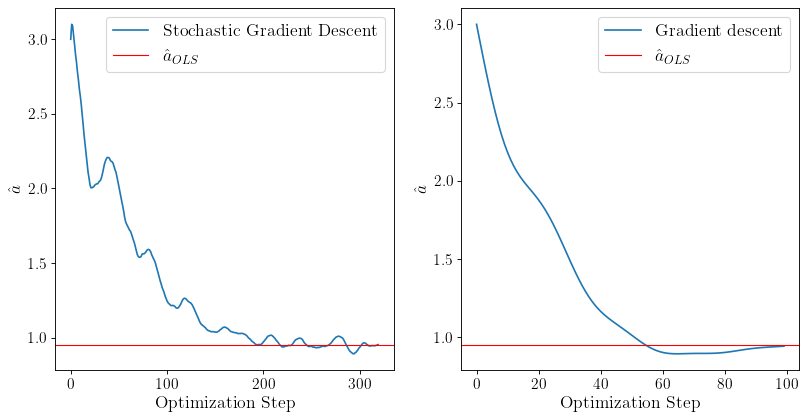

In [18]:
plt.subplot(1, 2, 1)
plt.plot(bias_SGD,label= r"Stochastic Gradient Descent")
plt.axhline(a_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{a}_{OLS}$" )
plt.xlabel(r"Optimization Step")
plt.ylabel(r"$\hat{a}$")
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(bias_GD,label= r"Gradient descent")
plt.axhline(a_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{a}_{OLS}$" )
plt.xlabel(r"Optimization Step")
plt.ylabel(r"$\hat{a}$")
plt.legend(loc='best')

plt.show()


#### Plotting $\hat{b}$

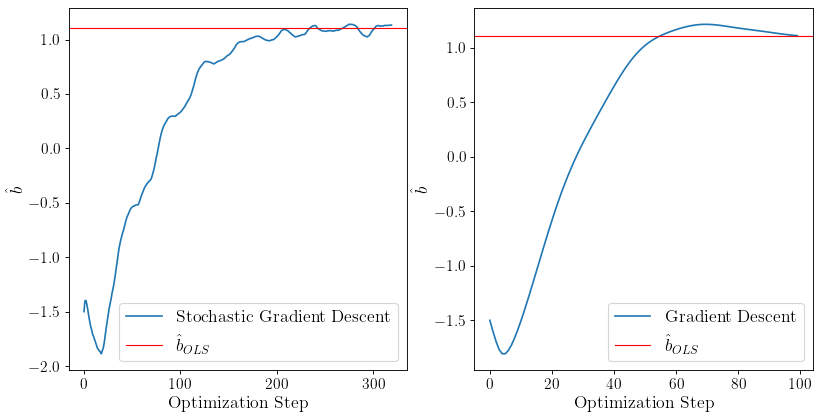

In [19]:
plt.subplot(1, 2, 1)
plt.plot(weight_SGD,label= r"Stochastic Gradient Descent")
plt.axhline(b_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{b}_{OLS}$")
plt.ylabel(r"$\hat{b}$")
plt.xlabel(r"Optimization Step")
plt.legend(loc='lower right')


plt.subplot(1,2,2)
plt.plot(weight_GD,label= r"Gradient Descent")
plt.axhline(b_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{b}_{OLS}$")
plt.ylabel(r"$\hat{b}$")
plt.xlabel(r"Optimization Step")
plt.legend(loc='lower right')
plt.show()


# Creating the gif 

In [20]:
fontsize= 16
ticksize = 14
figsize = (6, 3.5)
params = {"text.usetex": True,
    'font.family':'serif',
    "figure.figsize":figsize, 
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize, 
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params) 

In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio

In [22]:
filenames = []
for i in range(len(weight_SGD)):
    # plot the line chart
    plt.plot(weight_SGD[:i],label= r"Stochastic Gradient Descent" )
    plt.axhline(b_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{b}_{OLS}$")
    plt.ylabel(r"$\hat{b}$")
    plt.xlabel(r"Optimization Step")
    plt.legend(loc='lower right')
    plt.ylim(-2.0,1.2)
    plt.xlim(0,320)
    plt.tight_layout()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer('SGD_LOS_b.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

In [23]:
filenames = []
for i in range(len(bias_SGD)):
    # plot the line chart
    plt.plot(bias_SGD[:i],label= r"Stochastic Gradient Descent" )
    plt.axhline(a_hat_ols.item(),linewidth=1, color='r', label = r"$\hat{a}_{OLS}$")
    plt.ylabel(r"$\hat{a}$")
    plt.xlabel(r"Optimization Step")
    plt.legend(loc='upper right')
    plt.ylim(0.5,3.0)
    plt.xlim(0,320)
    plt.tight_layout()
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
with imageio.get_writer('SGD_LOS_a.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)